In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom

In [2]:
class VaREstimator:
    def __init__(self, returns, alpha=0.05):
        self.returns = returns
        self.alpha = alpha

    def historical_var(self): #Function to Calculate Historical VaR
        return np.percentile(self.returns, self.alpha * 100)

    def parametric_var(self): #Function to Calculate Parametric VaR
        mean = np.mean(self.returns)
        std = np.std(self.returns)
        return norm.ppf(self.alpha, mean, std)

    def ewma_var(self, lambda_=0.94): #Using EWMA method
        ewma_variance = np.zeros_like(self.returns)
        ewma_variance[0] = np.var(self.returns)
        for t in range(1, len(self.returns)):
            ewma_variance[t] = lambda_ * ewma_variance[t - 1] + (1 - lambda_) * self.returns[t - 1]**2
        ewma_std = np.sqrt(ewma_variance)
        ewma_var_series = norm.ppf(self.alpha, 0, ewma_std)
        return ewma_var_series

In [3]:
class VaRBacktester:
    def __init__(self, returns, var_series, alpha=0.05):
        self.returns = returns
        self.var_series = var_series
        self.alpha = alpha
        self.breaches = self.returns < self.var_series
        self.num_breaches = self.breaches.sum()
        self.total_obs = len(returns)

    def kupiec_test(self): #Kupiec Test
        p_hat = self.num_breaches / self.total_obs
        p = self.alpha
        LR = -2 * (np.log(((1 - p) ** (self.total_obs - self.num_breaches) * p ** self.num_breaches)) -
                  np.log(((1 - p_hat) ** (self.total_obs - self.num_breaches) * p_hat ** self.num_breaches)))
        return LR

    def traffic_light(self): #Traffic Light Method
        green_zone = binom.ppf(0.95, self.total_obs, self.alpha)
        yellow_zone = binom.ppf(0.999, self.total_obs, self.alpha)
        if self.num_breaches <= green_zone:
            return "Green"
        elif self.num_breaches <= yellow_zone:
            return "Yellow"
        else:
            return "Red"

    def binomial_test(self): #Binomial Test
        p_value = binom.cdf(self.num_breaches, self.total_obs, self.alpha)
        return p_value

    def tuff_test(self): #TUFF method
        window_size = int(0.1 * self.total_obs)
        rolling_breaches = pd.Series(self.breaches).rolling(window=window_size).sum().dropna()
        threshold = binom.ppf(0.99, window_size, self.alpha)
        fail_count = (rolling_breaches > threshold).sum()
        return fail_count

In [4]:
class VaRPlotter:
    def __init__(self, returns, historical_var_value, parametric_var_value, ewma_var_series):
        self.returns = returns
        self.historical_var_value = historical_var_value
        self.parametric_var_value = parametric_var_value
        self.ewma_var_series = ewma_var_series

    def plot_combined_var(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.returns, label='Returns', color='blue')
        plt.plot(self.ewma_var_series, label='EWMA VaR (5%)', color='red', linestyle='--')
        plt.axhline(self.historical_var_value, color='green', linestyle='--', label='Historical VaR (5%)')
        plt.axhline(self.parametric_var_value, color='purple', linestyle='--', label='Parametric VaR (5%)')
        plt.title('Combined VaR Approaches')
        plt.xlabel('Time')
        plt.ylabel('Value at Risk')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_backtest_breaches(self, breaches):
        plt.figure(figsize=(14, 6))
        plt.plot(self.returns, label='Returns', color='blue')
        plt.plot(self.returns[breaches], 'ro', markersize=4, label='Breaches')
        plt.title('VaR Backtest Breaches Over Time')
        plt.xlabel('Time')
        plt.ylabel('Return')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [5]:
class ExpectedShortfallEstimator:
    def __init__(self, returns, alpha=0.05):
        self.returns = returns
        self.alpha = alpha

    def historical_es(self): #Historical method
        var = np.percentile(self.returns, self.alpha * 100)
        return self.returns[self.returns <= var].mean()

    def parametric_es(self): #Parametric method using Normal Distribution
        mean = np.mean(self.returns)
        std = np.std(self.returns)
        z = norm.ppf(self.alpha)
        return mean - std * norm.pdf(z) / self.alpha

    def ewma_es(self, lambda_=0.94): #EWMA method
        ewma_variance = np.zeros_like(self.returns)
        ewma_variance[0] = np.var(self.returns)
        for t in range(1, len(self.returns)):
            ewma_variance[t] = lambda_ * ewma_variance[t - 1] + (1 - lambda_) * self.returns[t - 1]**2
        ewma_std = np.sqrt(ewma_variance)
        z = norm.ppf(self.alpha)
        return - ewma_std * norm.pdf(z) / self.alpha

In [6]:
class ESBacktester:
    def __init__(self, returns, es_series, alpha=0.05):
        self.returns = returns
        self.es_series = np.asarray(es_series)
        self.alpha = alpha
        self.breaches = self.returns < self.es_series
        self.num_breaches = self.breaches.sum()
        self.total_obs = len(returns)
 
    def kupiec_test(self): #Kupiec test
        p_hat = self.num_breaches / self.total_obs
        p = self.alpha
        LR = -2 * (np.log(((1 - p) ** (self.total_obs - self.num_breaches) * p ** self.num_breaches)) -
                  np.log(((1 - p_hat) ** (self.total_obs - self.num_breaches) * p_hat ** self.num_breaches)))
        return LR

    def traffic_light(self): #traffic light method
        green_zone = binom.ppf(0.95, self.total_obs, self.alpha)
        yellow_zone = binom.ppf(0.999, self.total_obs, self.alpha)
        if self.num_breaches <= green_zone:
            return "Green"
        elif self.num_breaches <= yellow_zone:
            return "Yellow"
        else:
            return "Red"

    def binomial_test(self): #Binomial method
        p_value = binom.cdf(self.num_breaches, self.total_obs, self.alpha)
        return p_value

    def tuff_test(self): #TUFF method
        window_size = int(0.1 * self.total_obs)
        rolling_breaches = pd.Series(self.breaches).rolling(window=window_size).sum().dropna()
        threshold = binom.ppf(0.99, window_size, self.alpha)
        fail_count = (rolling_breaches > threshold).sum()
        return fail_count

In [7]:
class ESPlotter:
    def __init__(self, returns, historical_es_value, parametric_es_value, ewma_es_series):
        self.returns = returns
        self.historical_es_value = historical_es_value
        self.parametric_es_value = parametric_es_value
        self.ewma_es_series = ewma_es_series

    def plot_combined_es(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.returns, label='Returns', color='blue')
        plt.plot(self.ewma_es_series, label='EWMA ES (5%)', color='red', linestyle='--')
        plt.axhline(self.historical_es_value, color='green', linestyle='--', label='Historical ES (5%)')
        plt.axhline(self.parametric_es_value, color='purple', linestyle='--', label='Parametric ES (5%)')
        plt.title('Combined ES Approaches')
        plt.xlabel('Time')
        plt.ylabel('Expected Shortfall')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_backtest_breaches(self, breaches):
        plt.figure(figsize=(14, 6))
        plt.plot(self.returns, label='Returns', color='blue')
        plt.plot(self.returns[breaches], 'ro', markersize=4, label='ES Breaches')
        plt.title('ES Backtest Breaches Over Time')
        plt.xlabel('Time')
        plt.ylabel('Return')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [8]:
class ReturnAnalyzer: #This is to study returns on the portfolio and individual stocks
    def __init__(self, returns_df, portfolio_column='Portfolio'):
        self.returns_df = returns_df
        self.portfolio_column = portfolio_column

    def descriptive_stats(self):
        return self.returns_df.describe()

    def plot_returns(self):
        plt.figure(figsize=(14, 6))
        for column in self.returns_df.columns:
            plt.plot(self.returns_df[column], label=column)
        plt.title('Daily Returns of Individual Stocks and Portfolio')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [9]:
# Load stock data from CSV files
amzn_data = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
aapl_data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
msft_data = pd.read_csv('MSFT.csv', parse_dates=['Date'], index_col='Date')

# Combine stock data into a single DataFrame
stock_data = pd.DataFrame({
    'AMZN': amzn_data['Adjusted Close'],
    'AAPL': aapl_data['Adjusted Close'],
    'MSFT': msft_data['Adjusted Close']
})

# Define stock tickers
stocks = ['AMZN', 'AAPL', 'MSFT']

# Define weights of the stocks in the portfolio
weights = {
    'AMZN': 0.4,
    'AAPL': 0.3,
    'MSFT': 0.3
}

weights = {'AMZN': 0.4, 'AAPL': 0.3, 'MSFT': 0.3}
returns = stock_data.pct_change().dropna()
returns['Portfolio'] = sum(returns[col] * weights[col] for col in weights)
portfolio_returns = returns['Portfolio'].dropna().values

# VaR Estimation
var_estimator = VaREstimator(portfolio_returns)
historical_var_value = var_estimator.historical_var()
parametric_var_value = var_estimator.parametric_var()
ewma_var_series = var_estimator.ewma_var()

# Expected Shortfall Estimation
es_estimator = ExpectedShortfallEstimator(portfolio_returns)
historical_es = es_estimator.historical_es()
parametric_es = es_estimator.parametric_es()
ewma_es_series = es_estimator.ewma_es()

# Backtesting
var_backtester = VaRBacktester(portfolio_returns, ewma_var_series)
kupiec_stat = var_backtester.kupiec_test()
traffic = var_backtester.traffic_light()
binomial_p = var_backtester.binomial_test()
tuff_result = var_backtester.tuff_test()

es_backtester = ESBacktester(portfolio_returns, ewma_es_series)
es_kupiec_stat = es_backtester.kupiec_test()
es_traffic = es_backtester.traffic_light()
es_binomial_p = es_backtester.binomial_test()
es_tuff_result = es_backtester.tuff_test()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2156\622511007.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amzn_data = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2156\622511007.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  aapl_data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2156\622511007.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  msft_data = pd.read_csv('MSFT.csv', parse_dates=['Date'], index_col='Date'

In [10]:
# Descriptive statistics
return_analyzer = ReturnAnalyzer(returns)
stats = return_analyzer.descriptive_stats()
print("Descriptive Statistics:\n", stats)

Descriptive Statistics:
               AMZN         AAPL         MSFT    Portfolio
count  6528.000000  6528.000000  6528.000000  6528.000000
mean      0.014830     0.011084     0.003956     0.010444
std       0.171632     0.150565     0.083826     0.113418
min      -0.866945    -0.703805    -0.489865    -0.622309
25%      -0.022031    -0.019660    -0.015115    -0.014737
50%       0.001792     0.002652     0.001189     0.003082
75%       0.036376     0.032769     0.022639     0.028919
max       2.087133     2.947606     0.903974     1.492806


In [11]:
# Output
print(f"Historical VaR (5%): {historical_var_value:.4f}")
print(f"Parametric VaR (5%): {parametric_var_value:.4f}")
print(f"EWMA VaR (5%) Last Value: {ewma_var_series[-1]:.4f}")
print(f"Historical ES (5%): {historical_es:.4f}")
print(f"Parametric ES (5%): {parametric_es:.4f}")
print(f"EWMA ES (5%) Last Value: {ewma_es_series[-1]:.4f}")
print(f"Kupiec Test Statistic (VaR): {kupiec_stat:.4f}")
print(f"Traffic Light Result (VaR): {traffic}")
print(f"Binomial Test p-value (VaR): {binomial_p:.4f}")
print(f"TUFF Test breach windows (VaR): {tuff_result}")
print(f"Kupiec Test Statistic (ES): {es_kupiec_stat:.4f}")
print(f"Traffic Light Result (ES): {es_traffic}")
print(f"Binomial Test p-value (ES): {es_binomial_p:.4f}")
print(f"TUFF Test breach windows (ES): {es_tuff_result}")

Historical VaR (5%): -0.1437
Parametric VaR (5%): -0.1761
EWMA VaR (5%) Last Value: -0.2232
Historical ES (5%): -0.2450
Parametric ES (5%): -0.2235
EWMA ES (5%) Last Value: -0.2799
Kupiec Test Statistic (VaR): nan
Traffic Light Result (VaR): Green
Binomial Test p-value (VaR): 0.4830
TUFF Test breach windows (VaR): 0
Kupiec Test Statistic (ES): nan
Traffic Light Result (ES): Green
Binomial Test p-value (ES): 0.0000
TUFF Test breach windows (ES): 0


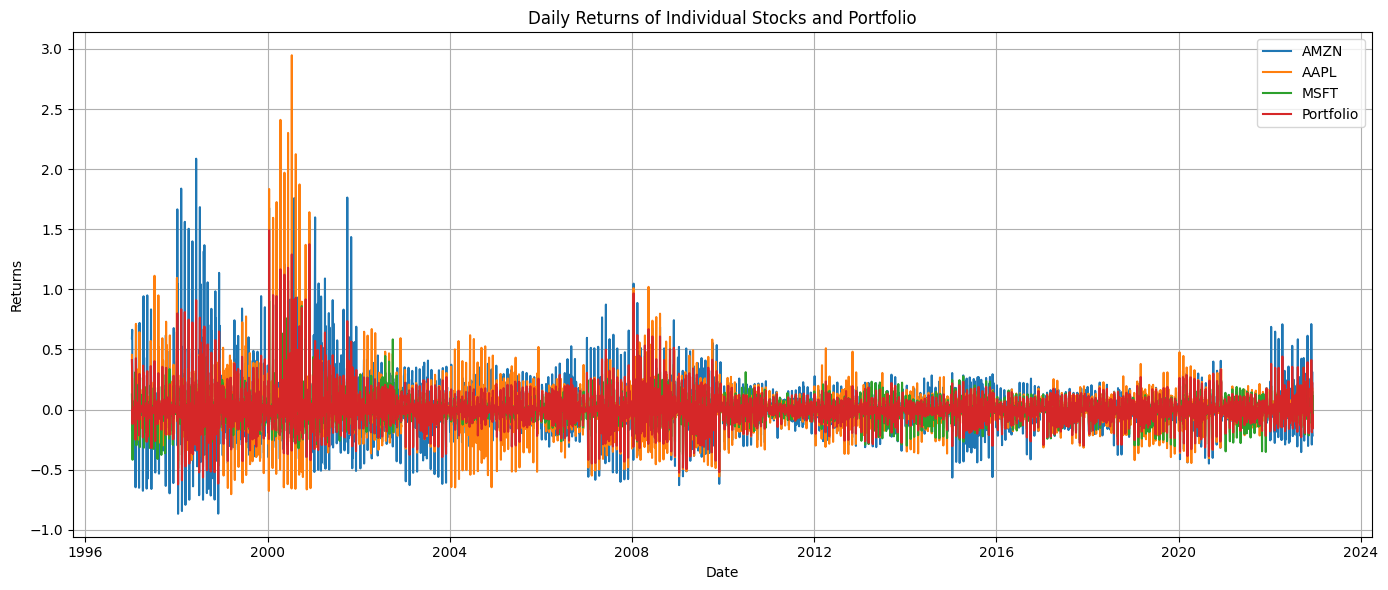

In [12]:
# Plot and describe returns
return_analyzer.plot_returns()

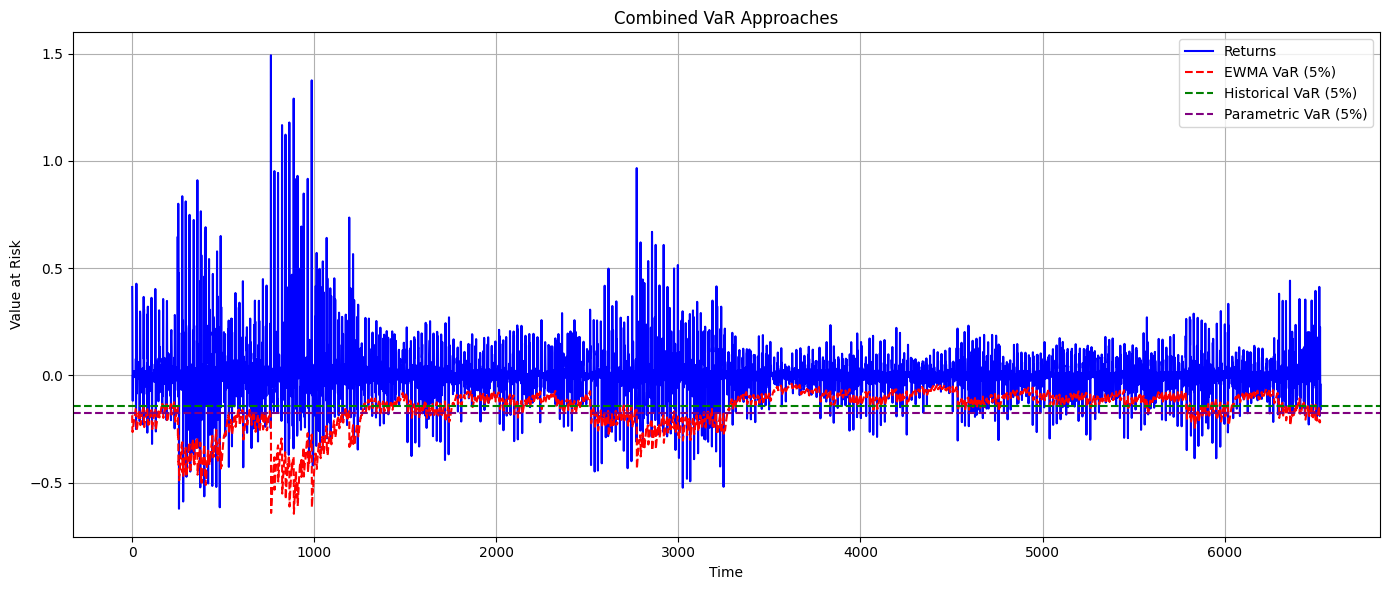

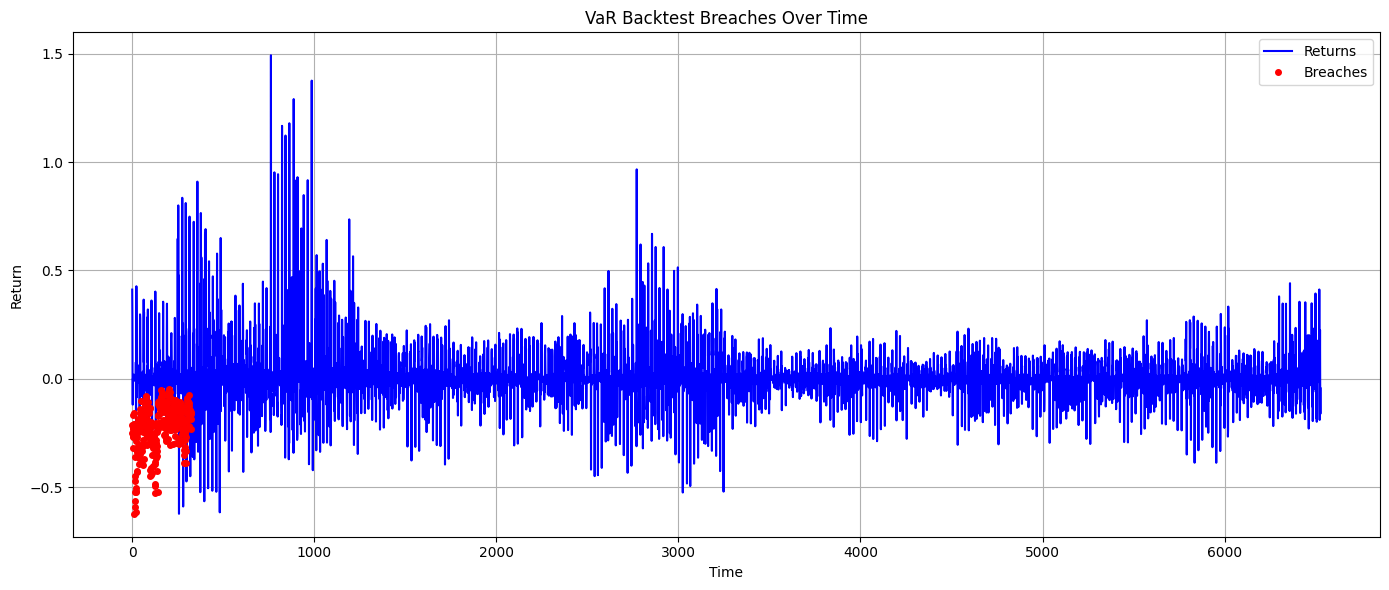

In [13]:
#Plot VaR
var_plotter = VaRPlotter(portfolio_returns, historical_var_value, parametric_var_value, ewma_var_series)
var_plotter.plot_combined_var()
var_plotter.plot_backtest_breaches(var_backtester.breaches)

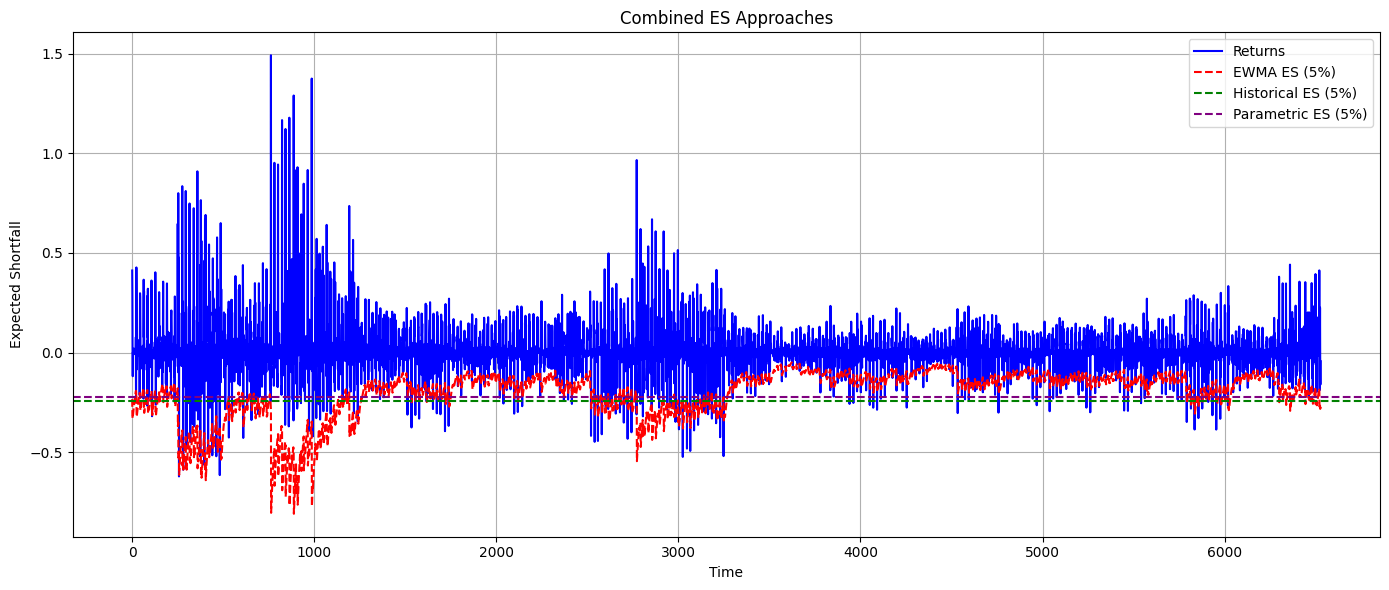

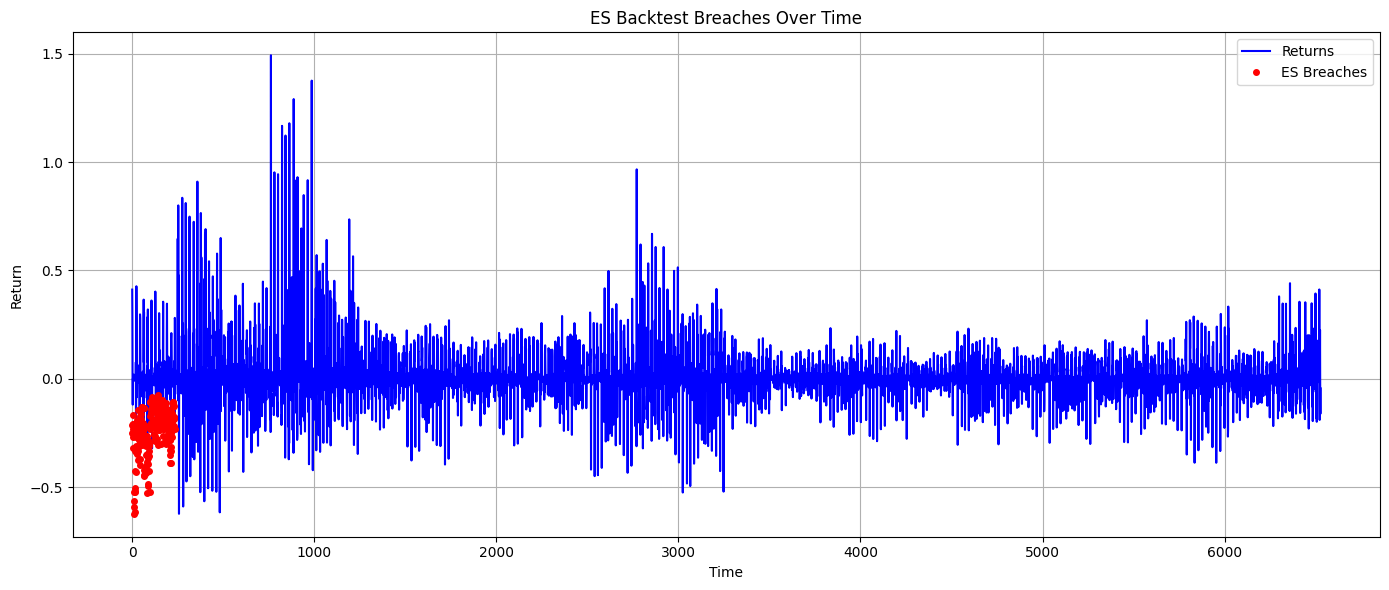

In [14]:
#Plot Expected Shortfall
es_plotter = ESPlotter(portfolio_returns, historical_es, parametric_es, ewma_es_series)
es_plotter.plot_combined_es()
es_plotter.plot_backtest_breaches(es_backtester.breaches)